In [128]:
import torch
import torch.nn.functional as f
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [130]:
clean_hin_dataset = open("datasets\cleaned_hinenglish.txt").read().splitlines()

In [131]:
#building the mappings like tokeniser

clean = sorted(set(''.join(clean_hin_dataset)))
stoi = {s:i for i,s in enumerate(clean)}
stoi['.'] = 27
itos = {i:s for s,i in stoi.items()}
vocab_size = len(stoi)
data_size = len(clean_hin_dataset)
hidden_size = 100


In [132]:
# Convert all text into a single string
full_text = ' '.join(clean_hin_dataset)
full_text_idx = [stoi[ch] for ch in full_text]  # Convert to indices

seq_length = 25  # sliding window size
Xtrain, Ytrain = [], []

for i in range(len(full_text_idx) - seq_length):
    Xtrain.append(full_text_idx[i : i + seq_length])
    Ytrain.append(full_text_idx[i + 1 : i + seq_length + 1])

Xtrain = torch.tensor(Xtrain, dtype=torch.long)
Ytrain = torch.tensor(Ytrain, dtype=torch.long)

print("Xtrain shape:", Xtrain.shape)  # (num_examples, 25)
print("Ytrain shape:", Ytrain.shape)  # (num_examples, 25)

Xtrain shape: torch.Size([131399, 25])
Ytrain shape: torch.Size([131399, 25])


In [137]:
g = torch.Generator().manual_seed(2347243647)
Wxh = torch.randn((hidden_size, vocab_size), generator=g ) * 0.01    # (100,28)
Whh = torch.randn((hidden_size, hidden_size), generator=g ) * 0.01  # (100,100)
Why = torch.randn((vocab_size, hidden_size), generator=g) * 0.01  # (28,100)
bh = torch.zeros((hidden_size, 1)) # hidden bias (100,1)
by = torch.zeros((vocab_size, 1)) # output bias (28,1)
parameters = [Wxh, Whh, Why, bh, by]

In [138]:
for p in parameters:
    p.requires_grad = True  # Enable gradient tracking for all parameters

In [139]:
steps, lossi = [], []

In [146]:
X.shape, Y.shape

(torch.Size([25]), torch.Size([25]))

In [156]:
idx = torch.randint(0, len(Xtrain), (batch_size,))


X= Xtrain[idx]
Y = Ytrain[idx]


X.shape, Y.shape

(torch.Size([32, 25]), torch.Size([32, 25]))

In [ ]:
seq_length = 25
batch_size = 32
xs, hs, ys, ps = {}, {}, {}, {}
X = Xtrain[0]   #25
Y = Ytrain[0] #25

#initialise hprev to zeros
hs[-1] = torch.zeros((hidden_size, 1))
for i in range(10000):
   #idx = torch.randint(0, len(Xtrain), (batch_size,))

   #X = Xtrain[idx]
   #Y = Ytrain[idx]
   loss = 0
#--------------------------------------------------------------------Forward Pass------------------------------------------#
   for t in range(seq_length):
      xs[t] = torch.zeros((vocab_size, 1))  # one-hot encoding (28,1)
      xs[t][X[t]] = 1  # set the index to 1   
      hs[t] = torch.tanh(Wxh @ xs[t] + Whh @ hs[t-1] + bh) #(100,1) 
      ys[t] = Why @ hs[t] + by  # logits (28,1) 
      ps[t] = f.softmax(ys[t], dim=0)  # normalized logits (28,1
      loss = loss + f.cross_entropy(ys[t].T, torch.tensor([Y[t]]))  #loss(acculamulated) is sequence wise as all the predictions should be right, also weights are shared across the sequence

#--------------------------------------------------------------------backward pass------------------------------------------#
   for p in parameters:
      p.grad = None
   loss.backward()

   torch.nn.utils.clip_grad_norm_(parameters, 5)

   
   # Update parameters using gradient descent
   lr = 0.001  # learning rate
   for p in parameters:
      p.data -= lr * p.grad


   steps.append(i)
   lossi.append(loss.item())

    # Detach hidden state for next iteration
   hs[-1] = torch.zeros((hidden_size, 1))


   if i % 1000 == 0:
      print(f"Step {i}, Loss: {loss.item()}")

print(f"Final loss: {loss.item()}")

RuntimeError: a Tensor with 32 elements cannot be converted to Scalar

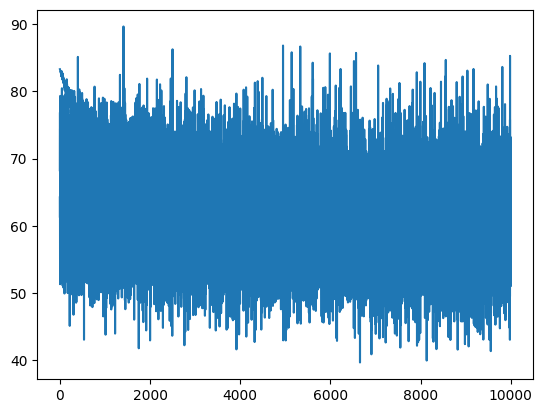

In [145]:
plt.plot(steps, lossi)

In [126]:
print(Wxh.grad.max(), Wxh.grad.min())

tensor(0.) tensor(0.)
